In [1]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

In [2]:
identifier_name = 'flight_id'

top_features_names = [
    'wtc', 
    'aircraft_type', 
    'flown_distance', 
    'groundspeed_max', 
    'latitude_min', 
    'altitude_25percentile', 
    'airline', 
    'flight_duration', 
    'longitude_max', 
    'vertical_rate_75percentile', 
    'altitude_median', 
    'ades', 
    'longitude_mean', 
    'altitude_75percentile', 
    'latitude_75percentile', 
    'vertical_rate_std', 
    'adep', 
    'latitude_std', 
    'vertical_rate_max', 
    'latitude_max', 
    'longitude_std', 
    'vertical_rate_25percentile', 
    'longitude_min', 
    'longitude_75percentile', 
    'altitude_mean', 
    'groundspeed_75percentile', 
    'country_code_adep', 
    'latitude_median', 
    'longitude_25percentile', 
    'groundspeed_min', 
    'country_code_ades', 
    'latitude_25percentile', 
    'actual_offblock_time_hour', 
    'longitude_median', 
    'month', 
    'altitude_std', 
    'latitude_count', 
    'taxiout_time', 
    'vertical_rate_median', 
    'month_day'
]

target_name = 'tow'

global_random_state = 123

In [3]:
encoded_challenge_set = pd.read_csv('data/encoded_challenge_set.csv')
encoded_challenge_set = encoded_challenge_set.fillna(0)
df = encoded_challenge_set[top_features_names+[target_name]]

In [4]:
all_mse = []
all_rmse = []
n_clusters = list(range(1, 15, 1))

for n in n_clusters:
    print(f"Trying n_clusters: {n}...")
    
    #scaler = StandardScaler()
    #df_scaled = scaler.fit_transform(data_df)
    
    data_df = df.copy()
    kmeans = KMeans(n_clusters=n, random_state=global_random_state)
    data_df['cluster'] = kmeans.fit_predict(data_df[top_features_names])

    mean_mse_score = []
    mean_rmse_score = []
    for cluster_nr in range(0, n, 1):
        cluster_df = data_df[data_df['cluster'] == cluster_nr]
        
        X = cluster_df[top_features_names]
        y = cluster_df[target_name]
        if cluster_df.empty:
            print(f"---> No samples in this cluster number: {cluster_nr}")
            continue

        model = xgb.XGBRegressor(
            colsample_bytree=1.0,
            learning_rate=0.1, 
            max_depth=10, 
            n_estimators=91, 
            subsample=1.0,
            objective='reg:squarederror', 
            eval_metric='rmse',
            random_state=global_random_state
        )
        
        kf = KFold(n_splits=3, shuffle=True, random_state=global_random_state)
        scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
        mse_scores = -scores
        mean_mse = np.mean(mse_scores)
        mean_mse_score.append(mean_mse)
        rmse = np.sqrt(mean_mse)
        mean_rmse_score.append(rmse)
        print(f'---> cluster number: {cluster_nr}, has {len(cluster_df)} datapoint making {(len(cluster_df)/len(data_df))*100:.2f}% of original dataset, MSE: {mean_mse:.4f}, RMSE: {rmse}')

    n_clusters_mse_score = np.mean(mean_mse_score)
    all_mse.append(n_clusters_mse_score)
    n_clusters_rmse_score = np.mean(mean_rmse_score)
    all_rmse.append(n_clusters_rmse_score)
    print(f'***n_clusters={n}: MSE: {n_clusters_mse_score:.4f}, RMSE: {n_clusters_rmse_score}\n')

Trying n_clusters: 1...
---> cluster number: 0, has 369013 datapoint making 100.00% of original dataset, MSE: 9080649.9278, RMSE: 3013.4116757843794
***n_clusters=1: MSE: 9080649.9278, RMSE: 3013.4116757843794

Trying n_clusters: 2...
---> cluster number: 0, has 136568 datapoint making 37.01% of original dataset, MSE: 6821131.5057, RMSE: 2611.729600414511
---> cluster number: 1, has 232445 datapoint making 62.99% of original dataset, MSE: 10577830.7697, RMSE: 3252.3577247461462
***n_clusters=2: MSE: 8699481.1377, RMSE: 2932.0436625803286

Trying n_clusters: 3...
---> cluster number: 0, has 135926 datapoint making 36.84% of original dataset, MSE: 6901804.3888, RMSE: 2627.1285443994216
---> cluster number: 1, has 231874 datapoint making 62.84% of original dataset, MSE: 10628680.6959, RMSE: 3260.1657466867805
---> cluster number: 2, has 1213 datapoint making 0.33% of original dataset, MSE: 12619796.3385, RMSE: 3552.4352687315686
***n_clusters=3: MSE: 10050093.8077, RMSE: 3146.576519939256

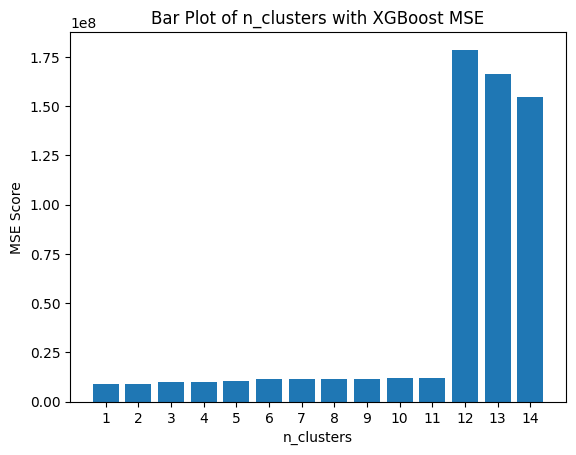

In [5]:
plt.bar(n_clusters, all_mse)
plt.title(f"Bar Plot of n_clusters with XGBoost MSE")
plt.xlabel("n_clusters")
plt.ylabel("MSE Score")
plt.xticks(ticks=n_clusters)
plt.show()
print()

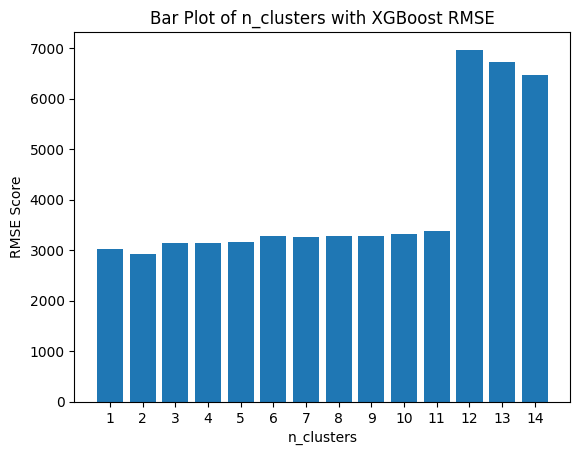

In [6]:
plt.bar(n_clusters, all_rmse)
plt.title(f"Bar Plot of n_clusters with XGBoost RMSE")
plt.xlabel("n_clusters")
plt.ylabel("RMSE Score")
plt.xticks(ticks=n_clusters)
plt.show()
print()

In [7]:
print(f"Minimum RMSE: ", all_rmse[np.argmin(all_rmse)])

Minimum RMSE:  2932.0436625803286


In [8]:
print(f"Number of clusters with minimum RMSE: ", n_clusters[np.argmin(all_rmse)])

Number of clusters with minimum RMSE:  2
